# Introduction
This is my third computer vision algorithm, and here I will use an better pre-trained base: Efficientnet-V2, to see if any improvement in accuracy can be achieved over the use of VGG-16, which gave rather disappointing results.  

This dataset contains 5335 images of healthy and dieased eyes, and has been pre-augmented using standard shifting, flipping and rotating processes.  In this version we are not including any further augmentation processes.

The dataset contains images of various eye diseases: Retinitis Pigmentosa, Retinal Detachment, Pterygium, Myopia, Macular Scar, Glaucoma, Disc Edema, Diabetic Retinopathy, Central Serous Chorioretinopathy, and also Healthy eye images. The classifications of this dataset have been done with the help of a domain expert from a healthcare institute.  Note that all images are of the back of the eye, expect in the case of Pterygium.  

As with many medical issues, early detection and treatment is key to preventing the most serious effects of eye disease, especially blindness.  If this dataset can be used to build a suitably accurate algorithm, it could be used in mobile clinics in remote areas where skilled opthamologists are in short supply.  It is not envisaged that the model would rule out the need for a full consultant assessment, but it would provide a rapid and relatively inexpensive method of flagging up those patients who have early, sub-clinical signs of disease.

# Data Input and Pre-Processing

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub

In [2]:
'''We need to construct a dataframe from which we split and flow the data.  
We will use the augmented dataset, and so avoid the processing needs of further augmentation.
Initialize empty lists to store image file paths and corresponding labels.'''

images = []
labels = []

# Loop through each subfolder in the dataset directory.
for subfolder in os.listdir('Augmented Dataset'):
    # Construct the full path to the subfolder.
       
    subfolder_path = os.path.join('Augmented Dataset', subfolder)
    # Loop through each category folder.
    for folder in os.listdir(subfolder_path):
        # Construct the full path to the category folder.
        subfolder_path2 = os.path.join(subfolder_path, folder)
        # Loop through each image file in the category folder.
        for image_filename in os.listdir(subfolder_path2):
            # Construct the full path to the image file.
            image_path = os.path.join(subfolder_path2, image_filename)
            # Append the image path to the images list.
            images.append(image_path)
            # Append the folder name (class label) to the labels list.
            labels.append(folder)
            
# Create a Pandas DataFrame with two columns: 'image' (file path) and 'label' (class label).
df = pd.DataFrame({'image': images, 'label': labels})
# Display the DataFrame to check this has worked correctly.
# df

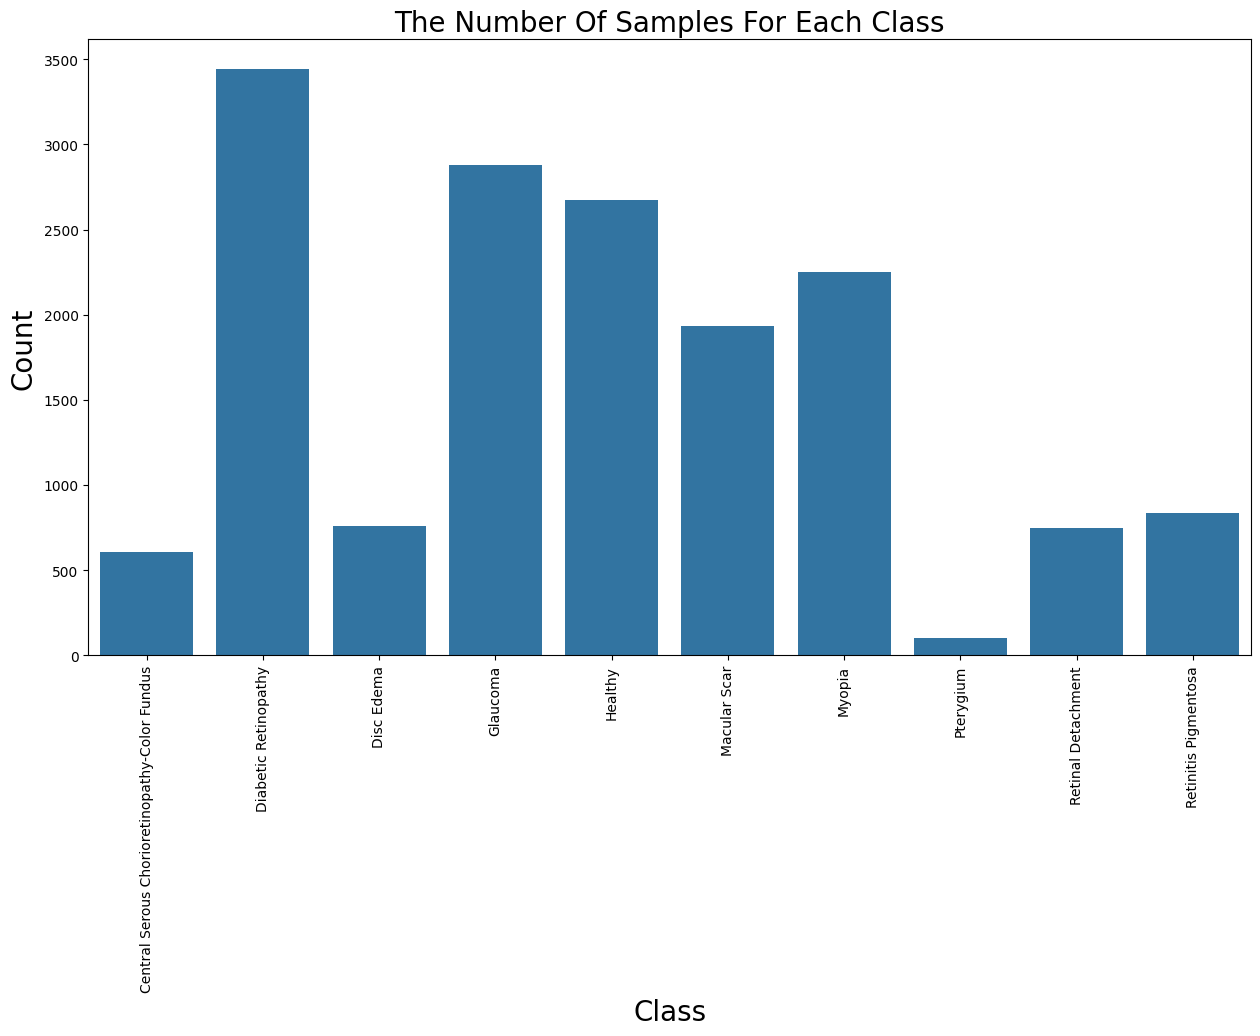

In [3]:
'''Is the data well balanced?  We shall use a  count plot to visualise this'''

plt.figure(figsize=(15, 8))

ax = sns.countplot(x=df.label)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.xticks(rotation=90)
plt.show()

There are a wide range of numbers of instances of each eye condition.  This will reduce the accuracy of any model, unless action is taken to better balance the data in each class.

We shall now visualise a small, random selection of the images.

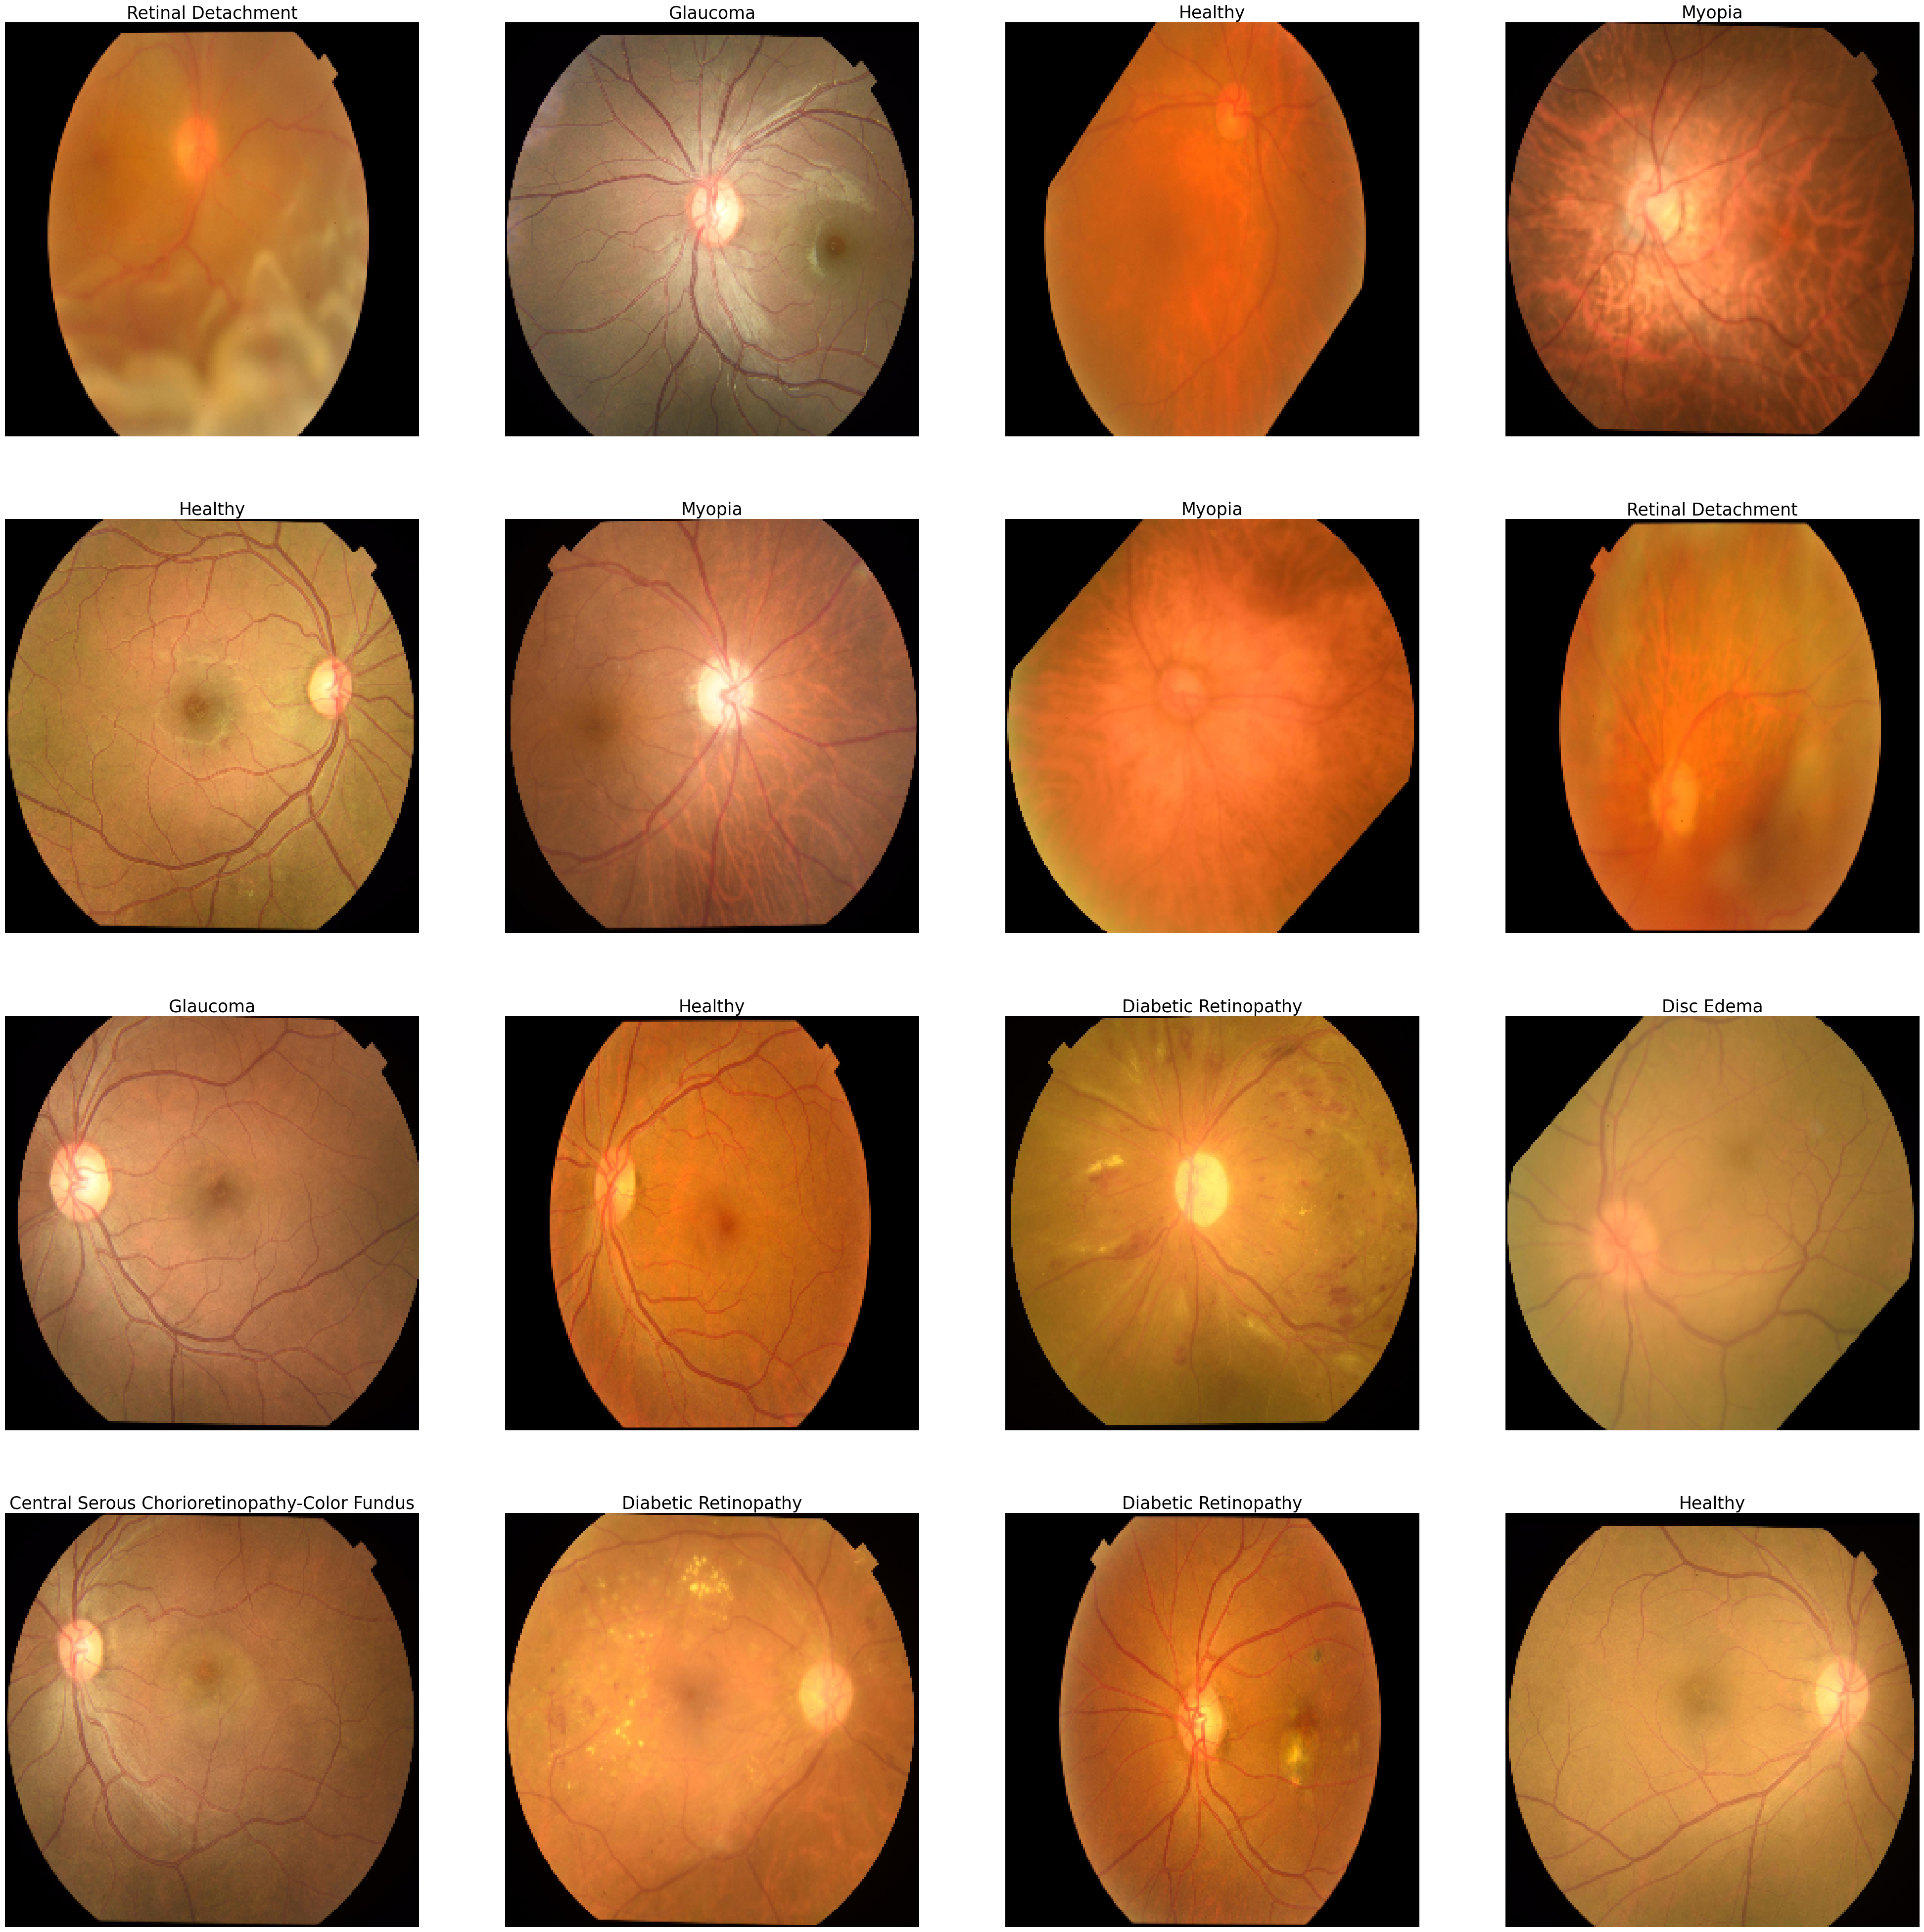

In [4]:
import cv2
# Create a figure with a large size for displaying the images in a grid
plt.figure(figsize=(50,50))
''' Loop over 16 random indices from the DataFrame `df` to display some images 
in a reasonably large format so that the user can discern the effects of the different pathologies.
Run mu;tiples times to display different images'''
for n, i in enumerate(np.random.randint(0, len(df), 16)):
    plt.subplot(4, 4, n+1)
    img = cv2.imread(df.image[i])
    # Resize the image to 224x224 pixels (standard input size for many models)
    img = cv2.resize(img, (224, 224))
    # Convert the image from BGR (OpenCV format) to RGB (for correct display with matplotlib)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i], fontsize=25)

In [5]:
from sklearn.model_selection import train_test_split

# Split into train and test sets, with validation set taken out in a further step
X_train, X_test1, y_train, y_test1 = train_test_split(
    df['image'],  # Features (images)
    df['label'],  # Labels (categories)
    test_size=0.2, 
    random_state=101,  # Fix random state for reproducibility, with a nod to Orwell
    shuffle=True,  # Shuffle dataset before splitting
    stratify=df['label']  # Ensure the label distribution is the same in both train and test sets
)
# Further split the initial test set (X_test1) into validation and final test sets, both of equal size
X_val, X_test, y_val, y_test = train_test_split(
    X_test1,  # Features (images) from the initial test set
    y_test1,  # Labels (categories) from the initial test set
    test_size=0.5,  # 10% of the initial dataset will be used for the final test set
    random_state=101,  # Fix random state for reproducibility, with a nod to Orwell
    shuffle=True,  # Shuffle the data before splitting
    stratify=y_test1  # Ensure the label distribution is the same in both validation and test sets
)
# Create a DataFrame for the training set with images and corresponding labels
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
# Create a DataFrame for the final test set with images and corresponding labels
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
# Create a DataFrame for the validation set with images and corresponding labels
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

# Tensorflow Model Definition

In [6]:
# Define the target image size and batch size for data processing
image_size = (224, 224)  # Resize all images to 224x224 pixels
batch_size = 32  # Number of images to process in each batch

'''Initialize the ImageDataGenerator for preprocessing, augmentation has been already done to
dataset that we are uploading.  '''
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,  
    rescale=1./255,  # Scale pixel values to the range [0, 1] by dividing by 255
    # width_shift_range = 0.15,   
    # height_shift_range = 0.15,
    # shear_range=0.15,
    # zoom_range=0.25,  leave this one out as it may remove the area under question
    # horizontal_flip=True,   previously used, leave out
    # vertical_flip=True,     previously used, leave out
    # fill_mode='nearest'
    ) 

# Create the training data generator using the train DataFrame (`df_train`)
train_generator = datagen.flow_from_dataframe(
    df_train,  
    x_col='image',  # Column containing image paths
    y_col='label',  # Column containing labels
    target_size=image_size, 
    batch_size=batch_size,  
    class_mode='categorical',  # Set class mode to categorical for multi-class classification
    shuffle=True)  # Shuffle the data for better training

# Create the test data generator using the test DataFrame (`df_test`) we use this at the end to generate metrics
test_generator = datagen.flow_from_dataframe(
    df_test,  # DataFrame containing images and labels
    x_col='image',  # Column containing image paths
    y_col='label',  # Column containing labels
    target_size=image_size,  
    batch_size=batch_size,  
    class_mode='categorical',  # Set class mode to categorical for multi-class classification
    shuffle=False)  # Do not shuffle the test data to maintain consistency during evaluation

# Create the validation data generator using the validation DataFrame (`df_val`)
val_generator = datagen.flow_from_dataframe(
    df_val,  # DataFrame containing images and labels
    x_col='image',  # Column containing image paths
    y_col='label',  # Column containing labels
    target_size=image_size,  
    batch_size=batch_size,  
    class_mode='categorical',  # Set class mode to categorical for multi-class classification
    shuffle=True  # Shuffle the validation data for better validation performance
)

Found 12993 validated image filenames belonging to 10 classes.
Found 1625 validated image filenames belonging to 10 classes.
Found 1624 validated image filenames belonging to 10 classes.


In [7]:
# Retrieve the class labels from the train_generator's class_indices and store them as a list
class_num = list(train_generator.class_indices.keys())
class_num

['Central Serous Chorioretinopathy-Color Fundus',
 'Diabetic Retinopathy',
 'Disc Edema',
 'Glaucoma',
 'Healthy',
 'Macular Scar',
 'Myopia',
 'Pterygium',
 'Retinal Detachment',
 'Retinitis Pigmentosa']

In [8]:
efficient_net = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",trainable=False)
    
model = keras.Sequential([
    efficient_net,
    keras.layers.Flatten(),  # Add a Flatten layer to reshape the output
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),  
    keras.layers.Dropout(0.5),  
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),  
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax'),# 10 classes
])

model.build((None, image_size[0], image_size[1], 3))

In [9]:
# Visualize and save the model architecture as an image file
tf.keras.utils.plot_model(
    model,             # The model you want to visualize
    to_file='eye_disease_model.png',  # The file path where the image will be saved
    show_shapes=True,     # Whether to display the shape of each layer's output (important for understanding the flow of data)
    show_layer_names=True, # Whether to display the names of the layers
    show_dtype=True,      # Whether to display the data type of the layers (e.g., float32)
    dpi=120             # The resolution of the saved image (higher DPI means better quality)
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("TensorFlow version:", tf.__version__)
print("GPUs:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except Exception as e:
        print(f"Could not set memory growth: {e}")
else:
    print("No GPU found. Training will use CPU.")

TensorFlow version: 2.10.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Could not set memory growth: Physical devices cannot be modified after being initialized


In [12]:
print(train_generator.class_indices)

{'Central Serous Chorioretinopathy-Color Fundus': 0, 'Diabetic Retinopathy': 1, 'Disc Edema': 2, 'Glaucoma': 3, 'Healthy': 4, 'Macular Scar': 5, 'Myopia': 6, 'Pterygium': 7, 'Retinal Detachment': 8, 'Retinitis Pigmentosa': 9}


In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy

# Set up a callback to save the best model (based on validation accuracy) during training
checkpoint_cb = ModelCheckpoint(
    "model_cnn_fyp.keras",         
    save_best_only=True           
)
# Set up early stopping to stop training if the validation loss doesn't improve for 5 consecutive epochs
early_stopping_cb = EarlyStopping(
    patience=5,                   
    restore_best_weights=True     
)
# Compile the model with Adam optimizer and categorical cross-entropy loss for multi-class classification
model.compile(
    optimizer='adam',               
    loss='categorical_crossentropy', 
    metrics=['accuracy']            
)
# Train the model on the training data, validate on the validation data, and use the callbacks defined above
model.fit(
    train_generator,                
    epochs=50,                      
    validation_data=val_generator,  
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Pull the training and validation metrics into a dataframe.
hist = pd.DataFrame(model.history.history)
# hist

In [ ]:
# Plot the training and validation metrics

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Train_Loss')  
plt.plot(hist['val_loss'], label='Validation_Loss')  
# Set the title for the plot
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Train_Accuracy')  
plt.plot(hist['val_accuracy'], label='Validation_Accuracy')  
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset using the test generator, getting the loss and accuracy
test_loss, acc = model.evaluate(test_generator)

print('Test Loss: ', test_loss)
print('Test Accuracy: ', acc)

In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)  # carrying inference using the loaded model
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
results = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
# results

In [ ]:
print("Visualisation of Actual and Predicted Diagnosis for 24 random images".center(115))
plt.figure(figsize=(30,90))
batch = next(test_generator)
images= batch[0]
for n in range(24):
    plt.subplot(24,4,n+1)
    img = cv2.imread(df.image[n])
    # Resize the image to 224x224 pixels (standard input size for many models)
    img = cv2.resize(img, (224, 224))
    # Convert the image from BGR (OpenCV format) to RGB (for correct display with matplotlib)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"\n Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.",fontsize=18)
plt.show()

In [ ]:
# Generate confusion matrix and classification report using the Test data

from sklearn.metrics import confusion_matrix, classification_report

CM = confusion_matrix(y_test, y_pred)

CM = sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', center=True, cbar=False, annot=True,
                 cmap='crest',
            xticklabels=class_num, yticklabels=class_num)



ClassificationReport = classification_report(y_test, y_pred, target_names=class_num)

print('Classification Report : \n ', ClassificationReport)

CM

# Conclusions

Using a more complex sequential CNN model with the Efficientnet-V2 pretrained base we have now achieved an overall accuracy of 88%, compared to the value of 81% for VGG-16.  Some conditions are significantly better calssified using this model, such as Central Serous Chorioretinopathy-Color Fundus, for which we now have a precison of 82% compared to only 58% with VGG-16.

Glaucoma - one of the most common but by no means less significant - eye conditions is now detected with a precision of 71%; the model can predict that the eye is either healthy, has a macular scar, or exhibits myopia.  The first of these three outcomes is the most concerning, but we have noted in a previous notebook that glaucoma is often tested using au automated pressure test.

This model exhibits very little over-fitting, improving our confidence.

In all, the model would be a good basis for flagging the need for further investigation for the following conditions, where a precision of greater than 90% have been achieved:
Diabetic Retinopathy (0.95), Disc Edema (0.99), Myopia (0.90), Pterygium (1.00), Retinal Detachment (0.96) and Retinitis Pigmentosa (0.92).  We note that for some of these the sample size is rather too small, and that the images for Pterygium are unique in being taken from the front of the eye.

As a final attempt to glean a higher degree of accuracy from this dataset, I will now experiment with increased augmentation, and will post any fruitful notebooks.

In [ ]:
# Save the trained model in HDF5 (.h5) format for later use
model.save('eye_disease_model.h5')
print("Model saved as eye_disease_model.h5")